# **EmployeeLeaveOrNot prediction with XGboost in Python**
This dataset contains 8 input features which are:

1. Education: Level of Education(Bachelors, Masters and PHD)
2. Joining year: The year of joining
3. City: To which city the employee belongs to
4. PaymentTier: Salary Tiers
5. Age: The age of the Employee
6. Gender: Male and Female
7. EverBenched: Everbenched (yes or no)
8. Experience in current domain: Employee experience in terms of years

And based on these input features, our main goal is to predict whether the Employee leave or not.

#### **1. Getting to know our data**

Let's get to know our columns and split our data into features and labels!

In [1]:
# Import libraries
import pandas as pd
import xgboost as xgb # XGBoost typically uses the alias "xgb"
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer,accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score


In [2]:
# Read in the dataset
employee = pd.read_csv("/kaggle/input/employee-dataset/Employee.csv")

# List out our columns
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [3]:
# Display Dataframe
employee.head(10)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
5,Bachelors,2016,Bangalore,3,22,Male,No,0,0
6,Bachelors,2015,New Delhi,3,38,Male,No,0,0
7,Bachelors,2016,Bangalore,3,34,Female,No,2,1
8,Bachelors,2016,Pune,3,23,Male,No,1,0
9,Masters,2017,New Delhi,2,37,Male,No,2,0


#### **2. Data Preprocessing**


In [4]:
# Display Missing Values
employee.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [5]:
# To check Is there any duplicate value in the dataset
employee.duplicated().sum()

1889

In [6]:
# Remove the duplicate values in the dataset
employee.drop_duplicates(inplace=True)

In [7]:
# Shape of dataframe after removing the duplicate values
employee.shape

(2764, 9)

**Feature Re-engineering**

Changing the "JoiningYear" column to "YearsWorkingForCompany" and representing it as the number of years an employee has been working for the company.
This transformation can help capture the continuous nature of the employee's tenure and potentially improve the model's ability to discern patterns related to employee retention.

In [8]:
assumed_collection_year = 2019
employee['YearsWorkingForCompany'] = assumed_collection_year - employee['JoiningYear']

# Drop the original 'JoiningYear' column if needed
employee = employee.drop('JoiningYear', axis=1)

In [9]:
# Changing the position of my new column
employee = employee[['Education', 'City', 'PaymentTier', 'Age', 'Gender', 'EverBenched', 'ExperienceInCurrentDomain', 'YearsWorkingForCompany', 'LeaveOrNot']]
# Display Dataframe
employee.head()

,Education,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,YearsWorkingForCompany,LeaveOrNot
0,Bachelors,Bangalore,3,34,Male,No,0,2,0
1,Bachelors,Pune,1,28,Female,No,3,6,1
2,Bachelors,New Delhi,3,38,Female,No,2,5,0
3,Masters,Bangalore,3,27,Male,No,5,3,1
4,Masters,Pune,3,24,Male,Yes,2,2,1


#### **3. Exploratory Data Analysis**


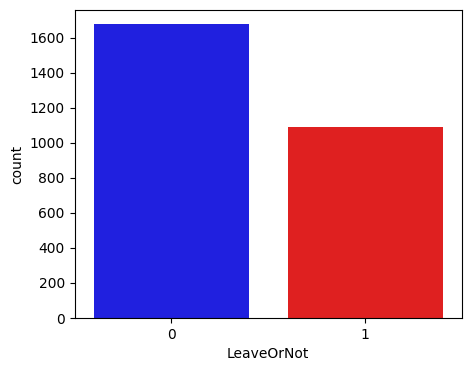

In [10]:
# Plot LeaveOrNot counts to visualize proportion of leave and not leave
plt.figure(figsize=(5,4))
sns.countplot(data=employee, x=employee["LeaveOrNot"], palette={0: "blue", 1: "red"})
plt.show()

In [11]:
# Get an exact percentage of leave and not leave
employee['LeaveOrNot'].value_counts()/employee['LeaveOrNot'].count()

LeaveOrNot
0    0.606368
1    0.393632
Name: count, dtype: float64

In [12]:
employee["Education"].value_counts()

Education
Bachelors    1971
Masters       637
PHD           156
Name: count, dtype: int64

<Axes: xlabel='Education', ylabel='count'>

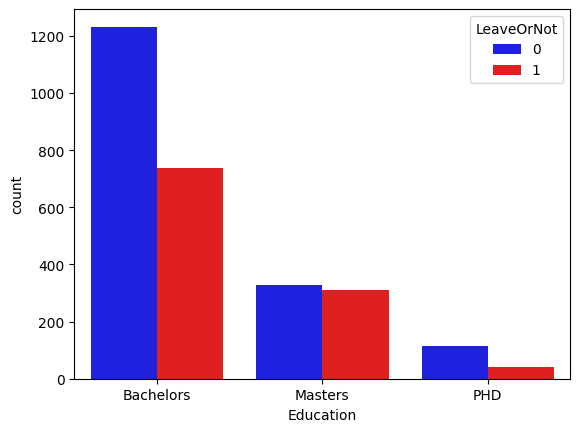

In [13]:
sns.countplot(data=employee, x= employee["Education"], hue="LeaveOrNot", palette={0: "blue", 1: "red"})

Here we can notice that almost half of the Masters Student Leave the job, whereas the more number of Bachelor's and PHD student stick to their jobs.



In [14]:
employee["Gender"].value_counts()

Gender
Male      1529
Female    1235
Name: count, dtype: int64

<Axes: xlabel='Gender', ylabel='count'>

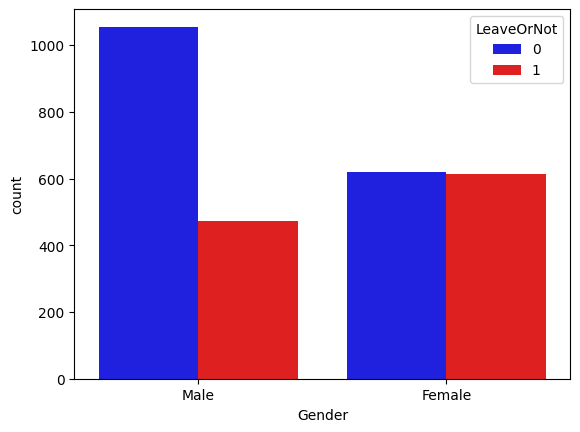

In [15]:
sns.countplot(data=employee, x= employee["Gender"], hue="LeaveOrNot", palette={0: "blue", 1: "red"})

Here we can see that half of the female leave their jobs,whereas the more no. of male candidates prefer to do the jobs.



In [16]:
employee["City"].value_counts()

City
Bangalore    1171
Pune          801
New Delhi     792
Name: count, dtype: int64

<Axes: xlabel='City', ylabel='count'>

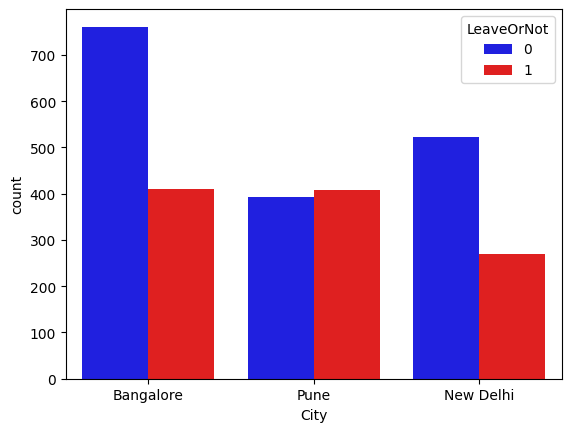

In [17]:
sns.countplot(data=employee, x= employee["City"], hue="LeaveOrNot",palette={0: "blue", 1: "red"})

This barchart indicates that in Pune City half of the people leave their jobs, whereas the Banglore and New Delhi are the cities where people are willing to do the jobs.

In [18]:
employee["EverBenched"].value_counts()

EverBenched
No     2403
Yes     361
Name: count, dtype: int64

<Axes: xlabel='EverBenched', ylabel='count'>

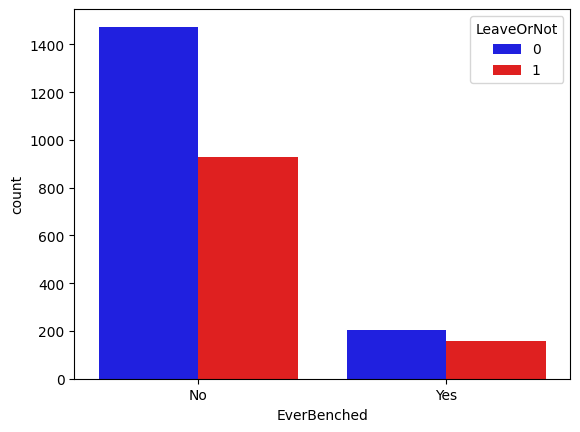

In [19]:
sns.countplot(data=employee, x= employee["EverBenched"], hue="LeaveOrNot", palette={0: "blue", 1: "red"})

In [20]:
employee["YearsWorkingForCompany"].value_counts()

YearsWorkingForCompany
2    662
4    464
6    396
5    385
3    310
7    308
1    239
Name: count, dtype: int64

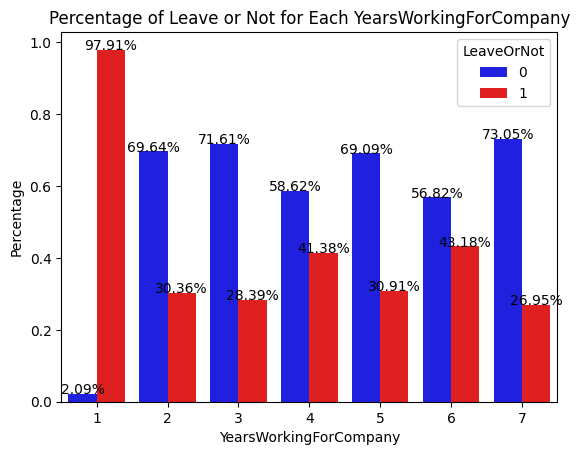

In [21]:
# Calculate percentages within each 'YearsWorkingForCompany' category
percentage_leave = (
    employee.groupby(['YearsWorkingForCompany', 'LeaveOrNot']).size() /
    employee.groupby('YearsWorkingForCompany').size()
).reset_index(name='Percentage')

# Create the countplot with percentages
ax = sns.barplot(data=percentage_leave, x='YearsWorkingForCompany', y='Percentage', hue='LeaveOrNot', palette={0: 'blue', 1: 'red'})

# Annotate the percentages on the bars
for p in ax.patches:
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + p.get_width()/2, y + height), ha='center')

plt.title('Percentage of Leave or Not for Each YearsWorkingForCompany')
plt.show()

Here we can see that small number of people leave their jobs if they have been working for 2+ years, compared to employees that have been working for 1 year

In [22]:
employee["PaymentTier"].value_counts()

PaymentTier
3    1976
2     570
1     218
Name: count, dtype: int64

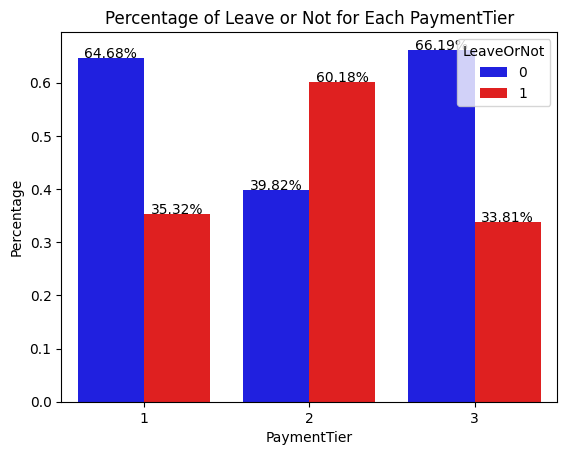

In [23]:
# Calculate percentages within each 'Payment Tier' category
percentage_leave = (
    employee.groupby(['PaymentTier', 'LeaveOrNot']).size() /
    employee.groupby('PaymentTier').size()
).reset_index(name='Percentage')

# Create the countplot with percentages
ax = sns.barplot(data=percentage_leave, x='PaymentTier', y='Percentage', hue='LeaveOrNot', palette={0: 'blue', 1: 'red'})

# Annotate the percentages on the bars
for p in ax.patches:
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + p.get_width()/2, y + height), ha='center')

plt.title('Percentage of Leave or Not for Each PaymentTier')
plt.show()

<Axes: xlabel='Age', ylabel='Count'>

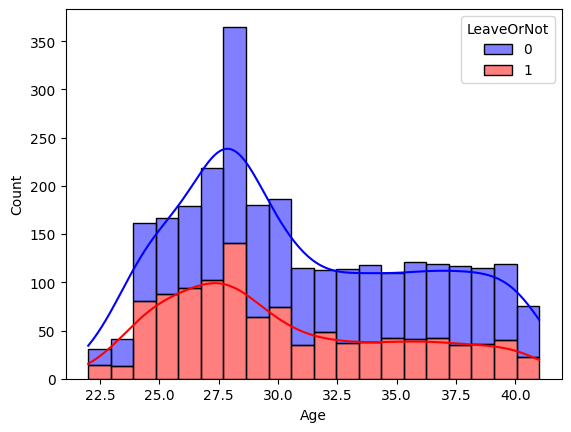

In [24]:
sns.histplot(data=employee, x=employee["Age"],hue="LeaveOrNot", kde=True, bins=20, multiple="stack", palette={0: "blue", 1: "red"})

From this representation, we observe that the more number of people, who ranges between the age of 22-26, prefer to change the jobs, whereas in the rest age group we see that more people prefer to stick to their jobs.

In [25]:
employee["ExperienceInCurrentDomain"].value_counts()

ExperienceInCurrentDomain
2    681
5    470
3    451
1    433
4    425
0    287
7      9
6      8
Name: count, dtype: int64

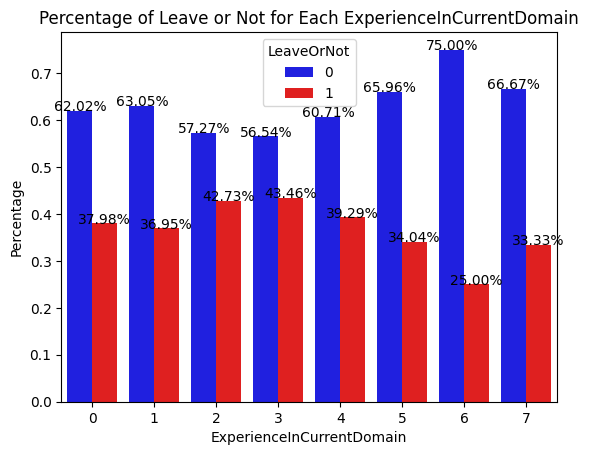

In [26]:
# Calculate percentages within each 'ExperienceInCurrentDomain' category
percentage_leave = (
    employee.groupby(['ExperienceInCurrentDomain', 'LeaveOrNot']).size() /
    employee.groupby('ExperienceInCurrentDomain').size()
).reset_index(name='Percentage')

# Create the countplot with percentages
ax = sns.barplot(data=percentage_leave, x='ExperienceInCurrentDomain', y='Percentage', hue='LeaveOrNot', palette={0: 'blue', 1: 'red'})

# Annotate the percentages on the bars
for p in ax.patches:
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + p.get_width()/2, y + height), ha='center')

plt.title('Percentage of Leave or Not for Each ExperienceInCurrentDomain')
plt.show()

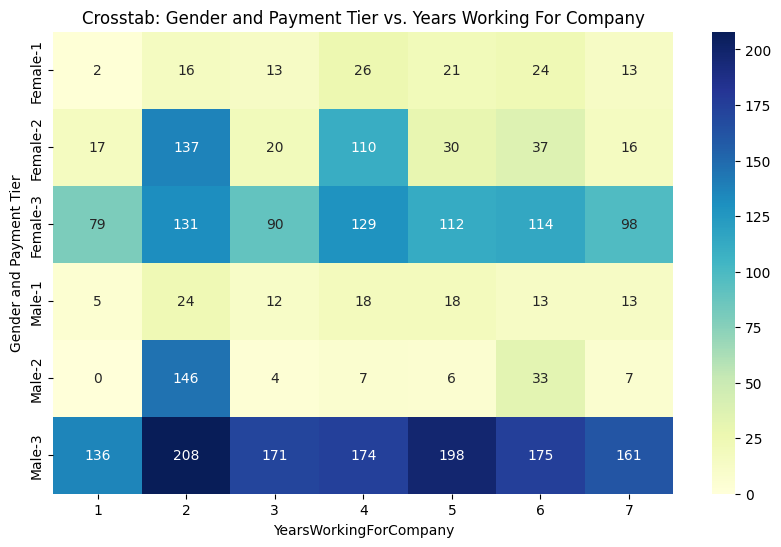

In [27]:
x=pd.crosstab([employee.Gender,employee.PaymentTier],employee.YearsWorkingForCompany)
plt.figure(figsize=(10, 6))
sns.heatmap(x, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('YearsWorkingForCompany')
plt.ylabel('Gender and Payment Tier')
plt.title('Crosstab: Gender and Payment Tier vs. Years Working For Company')
plt.show()

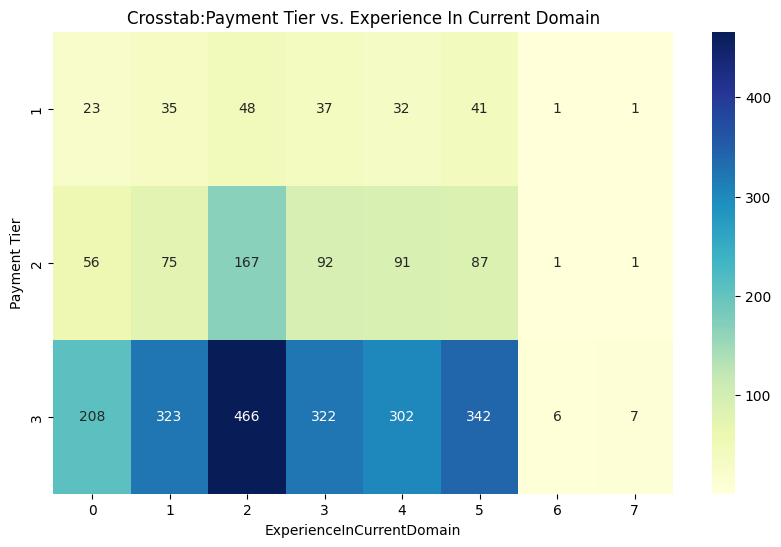

In [28]:
x=pd.crosstab(employee.PaymentTier,employee.ExperienceInCurrentDomain)
plt.figure(figsize=(10, 6))
sns.heatmap(x, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('ExperienceInCurrentDomain')
plt.ylabel('Payment Tier')
plt.title('Crosstab:Payment Tier vs. Experience In Current Domain')
plt.show()

**Label Encoding for Categorical Columns**

In [29]:
le=LabelEncoder()
employee["Education"]= le.fit_transform(employee["Education"])
employee["City"]=le.fit_transform(employee["City"])
employee["Gender"]=le.fit_transform(employee["Gender"])
employee["EverBenched"]=le.fit_transform(employee["EverBenched"])
employee.head(5)

,Education,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,YearsWorkingForCompany,LeaveOrNot
0,0,0,3,34,1,0,0,2,0
1,0,2,1,28,0,0,3,6,1
2,0,1,3,38,0,0,2,5,0
3,1,0,3,27,1,0,5,3,1
4,1,2,3,24,1,1,2,2,1


## **2. My First XGBoost Classifier**

### **Splitting data**
Let's split our label and features so we can get to building models! The last column is our target label `LeaveOrNot`. The rest are features.

In [30]:
# Define X and y
X, y = employee.iloc[:,:8], employee.iloc[:,8]

In [31]:
# Train and test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

# Instatiate a XGBClassifier 
xgb_clf=xgb.XGBClassifier(random_state=123)

# Inspect the parameters
xgb_clf.get_params()


{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [32]:
rs_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2,0.3],
    'n_estimators': [50,100, 200, 300, 400,500,600,700],
    'max_depth': [3, 4, 5, 6,8,10,12],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [0.5, 0.8, 1.0, 1.2],
}
# Insantiate XGBoost Clasifier 
xgb_clf = xgb.XGBClassifier(eval_metric='error', random_state=123)

scoring_metric = {
    'f1_score': make_scorer(f1_score),
}

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(estimator=xgb_clf, param_distributions=rs_param_grid, scoring=scoring_metric, cv=3, n_iter=50, refit='f1_score', verbose=1)
# Train the model on the training set
xgb_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found:", xgb_rs.best_params_)
print("Best f1 score found:", xgb_rs.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.9, 'scale_pos_weight': 1.2, 'reg_lambda': 2, 'reg_alpha': 0.2, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 0.9}
Best f1 score found: 0.700161082155457


To further refine your RandomizedSearchCV parameter grid, you can consider the following steps:

    Focus on Promising Parameters: Identify the parameters that consistently appear in the best models. In your case, subsample, scale_pos_weight, reg_lambda, n_estimators, max_depth, learning_rate, gamma, and colsample_bytree seem important. Consider narrowing down the ranges for these parameters.

    Fine-tune the Ranges: Based on the previous results, adjust the ranges of your parameters. If a parameter consistently has its best value within a specific range, you might want to focus your search in that range. For example, if learning_rate seems to work well in the range [0.01, 0.1], you can narrow it down to that range.

    Feature Interaction: Consider the interaction between different parameters. For example, if a specific combination of max_depth and learning_rate consistently results in good performance, you might want to explore more values around those combinations.

    Iterative Refinement: It's often beneficial to perform iterative refinement. After each round of RandomizedSearchCV, analyze the results, and use the insights to refine your parameter grid for the next iteration.

In [33]:
rs_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [1.0, 1.2, 1.4],
}
# Insantiate XGBoost Clasifier 
xgb_clf = xgb.XGBClassifier(eval_metric='error', random_state=123)

scoring_metric = {
    'f1_score': make_scorer(f1_score),
}

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(estimator=xgb_clf, param_distributions=rs_param_grid, scoring=scoring_metric, cv=3, n_iter=35, refit='f1_score', verbose=1)
# Train the model on the training set
xgb_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found:", xgb_rs.best_params_)
print("Best f1 score found:", xgb_rs.best_score_)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Best parameters found: {'subsample': 1.0, 'scale_pos_weight': 1.2, 'reg_lambda': 2, 'reg_alpha': 0.2, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best f1 score found: 0.7210297641386877


In [34]:
rs_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [200, 300, 400, 500, 600],
    'max_depth': [4, 5, 6, 8],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [2, 2.5, 3],
    'scale_pos_weight': [1.4, 1.6, 1.8],
}
# Insantiate XGBoost Clasifier 
xgb_clf = xgb.XGBClassifier(eval_metric='error', random_state=123)

scoring_metric = {
    'f1_score': make_scorer(f1_score),
}

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(estimator=xgb_clf, param_distributions=rs_param_grid, scoring=scoring_metric, cv=4, n_iter=200, refit='f1_score', verbose=1)
# Train the model on the training set
xgb_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found:", xgb_rs.best_params_)
print("Best f1 score found:", xgb_rs.best_score_)

Fitting 4 folds for each of 200 candidates, totalling 800 fits
Best parameters found: {'subsample': 0.9, 'scale_pos_weight': 1.4, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best f1 score found: 0.7249418152397042


In [35]:
# New best parameters found during randomized search
best_params = {
    'subsample': 1.0,
    'scale_pos_weight': 1.6,
    'reg_lambda': 2.5,
    'reg_alpha': 0,
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.01,
    'gamma': 0.3,
    'colsample_bytree': 0.8
}

# Instantiate XGBoost Classifier with new best parameters
best_model = xgb.XGBClassifier(**best_params, eval_metric='error', random_state=123)

# Train the model on the training set
best_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_new = best_model.predict(X_test)


In [36]:
# Obtain the best model from RandomizedSearchCV
best_model = xgb_rs.best_estimator_

# Predict probabilities on the validation set
y_prob = best_model.predict_proba(X_test)[:, 1]

# Define a range of thresholds to test
thresholds = np.arange(0.3, 0.6, 0.01)

# Initialize variables to keep track of the best threshold and corresponding F1 score
best_threshold = 0.5
best_f1_score = 0.0

# Iterate over thresholds
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_threshold = (y_prob > threshold).astype(int)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred_threshold)
    
    # Update best threshold if F1 score improves
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

# Print the best threshold and corresponding F1 score
print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1_score)

Best Threshold: 0.49000000000000016
Best F1 Score: 0.7093333333333334


In [37]:
# Set the threshold
threshold = 0.43

# Apply the threshold to obtain binary predictions
y_pred_binary = (y_prob > threshold).astype(int)

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7649186256781193
Precision: 0.6857142857142857
Recall: 0.6923076923076923
F1 Score: 0.6889952153110047


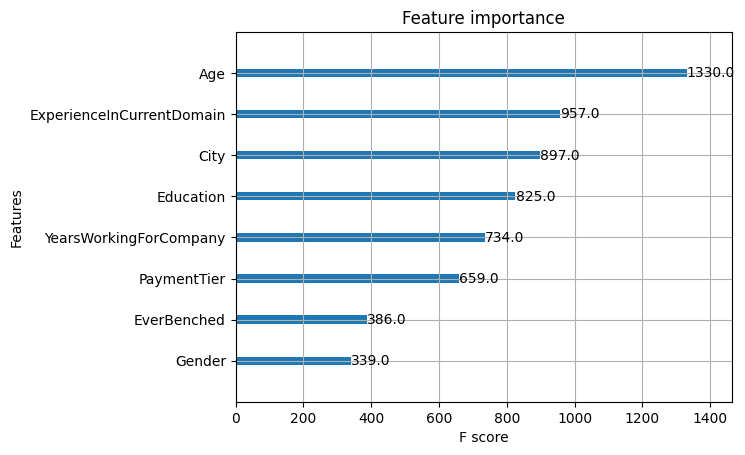

In [38]:
# Plot feature importance
xgb.plot_importance(best_model)
plt.show()

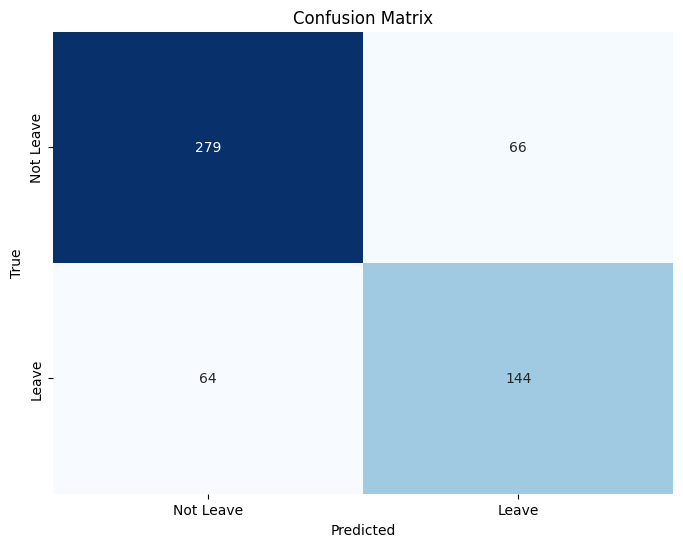

In [39]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Leave', 'Leave'],
            yticklabels=['Not Leave', 'Leave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

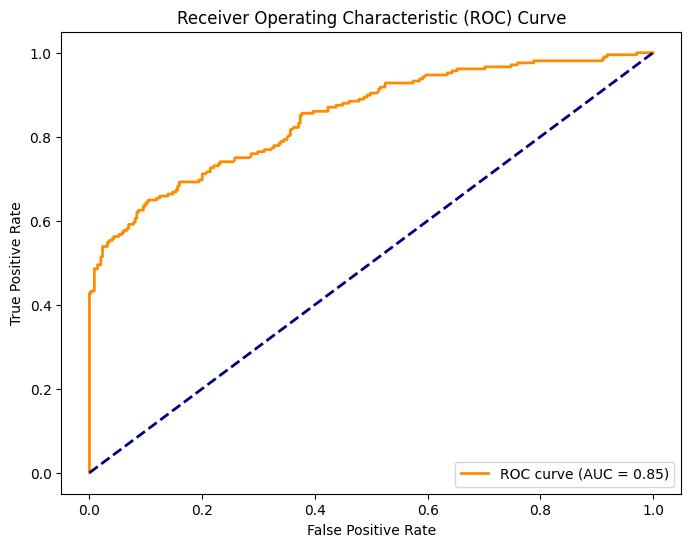

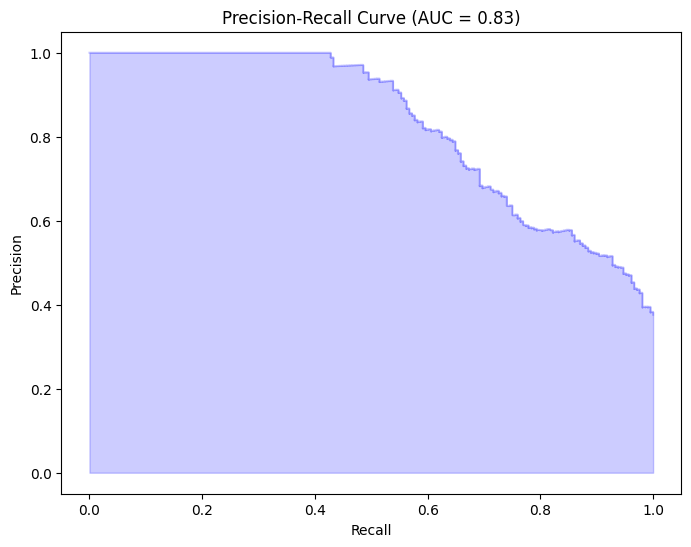

Accuracy: 0.80


In [40]:
# Predict probabilities for positive class
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUC = {:.2f})'.format(average_precision))
plt.show()

# Calculate and print accuracy
y_pred_binary = (y_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print('Accuracy: {:.2f}'.format(accuracy))